# Investigating hypotheses from trajectories
This notebook examines hypotheses generated from trajectory inspection, specifically:
1. Why do trajectories seem to end early?
2. Why does the model learn to use uncommonly high vasopressor doses?
3. Why does the model learn to expect discharge while on vasopressors?

This notebook generates Figures 5-6 and statistics in the Results: Investigation of questions raised by trajectory inspection section.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
data_prefix = ''

In [3]:
datapath = '<REPLACE WITH OUTPUT PATH>'
figpath = './figs'
import sys; sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import shelve
import numpy as np
import pandas as pd
from trajectoryInspection import mimic_utils as utils
from trajectoryInspection.mimic_config import colbin, collog, colnorm, feature_vars_map
from trajectoryInspection import mdp_utils as cf

# Avoid Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import logging as log
import sys
log.basicConfig(stream=sys.stdout, level=log.DEBUG)
log.getLogger('matplotlib').setLevel(log.WARNING)

from tqdm import tqdm_notebook as tqdm

In [4]:
nact = 25
ncl = 750
death_state_idx = ncl
lives_state_idx = ncl+1

soften_factor = 1e-3

N_HORIZON = 20
DISCOUNT=1.
n_mb_iter = 5
DISCOUNT_Pol=0.99 # Used for learning policies

In [5]:
# Read-only access to the data
data_dict = shelve.open("{}/{}data_dict.db".format(datapath,data_prefix), flag='r')

traj_train = data_dict['best_results']['traj_train']
traj_test = data_dict['traj_test']

np.random.seed(0)

In [6]:
colTime = 0
colAction = 1
colS0 = 2
colS1 = 3
colDiab = 4
colR = 6

In [7]:
# Used later to get per-trajectory summaries of rollouts
def get_summary_df(traj, is_cf=False):
    gb = ['icustayid', 'cf_index'] if is_cf else 'icustayid'
    
    df = traj.groupby(gb).agg(
    {'reward': 'sum', 
     'action_idx': ['count', 'last'], 
     'from_state_idx':['first', 'last']})

    df.columns = ['_'.join(col).rstrip('_') for col in df.columns.values]
    d = dict(zip(df.columns.values, ['reward', 'traj_len', 'final_action', 'initial_state', 'final_state']))
    df.rename(columns = d, inplace=True)
    
    return df

## Generate Train / Test Trajectories

For the "best" run of the replication script, we have a training set, a validation set, and a test set of trajectories.  For now, this just pulls the training set and the test set, leaving the validation set in storage

**Notation**: We have `train_samps` and `test_samps` which are in numpy format, padded to full length, used by the MDP samplers, as well as `traj_train` and `traj_test` which are in pandas format, used by the MDP creation scripts and not padded at all.  We retain `train_idx` and `test_idx` for the patient IDs that are used to keep track when we do model-based rollouts

In [8]:
# Keep the indices for later
test_idx_flat = data_dict['test_idx_flat']
test_idx = np.broadcast_to(test_idx_flat[:, np.newaxis], (test_idx_flat.shape[0], N_HORIZON))

test_samps = data_dict['test_samps']

In [9]:
"""
The "fill in gaps" operation is poorly named - it is designed to take the raw state / action / reward values, and convert to the (a, s, s') row-wise representation
while returning trajectories of the same original length.  This trimming can now be turned off, and the resulting operation is idempotent
"""
assert np.all(traj_train == utils.fill_in_gaps(traj_train, lives_state_idx, death_state_idx, trim_length=True))

# Convert trajectories to samples and retain full index
train_samps, train_idx = utils.fill_in_gaps(traj_train, lives_state_idx, death_state_idx, 
                                            trim_length=False, return_idx=True)

INFO:numexpr.utils:Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [10]:
t_pol = data_dict['best_results']['rl_pol']
raw_b_pol = data_dict['best_results']['obs_b']

## Generate Model-Based Rollouts for RAW

Here we generate rollouts conditioning on the training samples, using the **RAW** MDP and the **RAW** behavior policy.

*Note*: These are different from the model-based rollouts used in Section 5, because these are conditioned on the training data, as opposed to the test data

*Note*: This code block takes some time to run, but once it is finished, we recommend commenting it out and using the code block below to re-load the results

In [ ]:
np.random.seed(0)
rawMDP_dict = mdp_dict['train_raw']

# Model-based rollouts of the BEHAVIOR policy
rawMDP_dict['train_samps_mb_b'] = rawMDP_dict['sampler'].cf_trajectory(
    # Samples from which mb trajectories drawn
    train_samps,
    # Policy which is simulated
    cf_policy=raw_b_pol,
    n_cf_samps=n_mb_iter, use_tqdm=True,
    use_mb=True)

# Internal convention is to name samps by the set used to condition them, and then the policy, e.g.,
# train_samps_mb_b: Condition on training initial states, model-based with behavior policy
# test_samps_mb_t: Condition on test initial states, model-based with target policy

bad_states = np.where(raw_b_pol[t_pol > 0] == 0)[0]
print("There exist(s) {} state(s) where truncation (during training) removed all bpol actions".format(bad_states.shape[0]))
print("This makes up {:.5%} of total state distribution in training set".format(
traj_train.query('from_state_idx in @bad_states').shape[0] / traj_train.shape[0]))

# Note, this was never encountered with this particular random seed for the test samples, but it is an issue for the training samples
print("Replacing the learned policy with the behavior policy for those states")
t_pol[bad_states] = raw_b_pol[bad_states]

# Model-based rollouts of the TARGET policy
np.random.seed(0)
rawMDP_dict['train_samps_mb_t'] = rawMDP_dict['sampler'].cf_trajectory(
    # Samples from which mb trajectories drawn
    train_samps,
    # Policy which is simulated
    cf_policy=t_pol,
    n_cf_samps=n_mb_iter, use_tqdm=True,
    use_mb=True)

In [ ]:
# Back up our results
mb_dict = shelve.open("{}/mb_samples.db".format(datapath))
mb_dict['mdp_dict'] = mdp_dict
mb_dict.close()

In [11]:
# Re-load our results
mb_dict = shelve.open("{}/mb_samples.db".format(datapath), flag='r')
mdp_dict = mb_dict['mdp_dict']
mb_dict.close()

## Examine Aggregate Statistics

TL;DR: We base our conclusion that our results closely mirror that of the paper on the following observations:
* Recall that the paper did roll-outs *until a reward*, which is trickier for us to implement, as our rollouts stop at 20
* Nonetheless, the average MB reward over trajectory lengths is fairly constant, and close to the reward for the observed trajectories
* Thus, if we assume that the MB reward would continue to be fairly constant, then it indicates that the reported results in the paper should roughly hold

To be precise, we look at the expected MB reward, **conditioned** on ending at a certain time point.  In follow up analyses below, we will look at related questions that are of more interest, e.g., 
* At any given point in time, what is the likelihood of immediate transition to a positive / negative reward state?  We conjecture this is high, an artifact of using a homogenous MDP

## Mismatch in Dist. of Lengths

When using rollouts from the **RAW** MDP and behavior policy, we can recover similar results to those reported in the rebuttal by the authors.

**Limitation**:  We are currently set up to only generate model-based trajectories of the same length (or shorter) than the original trajectories.  Thus we cannot follow the strategy of the authors and roll out all model-based trajectories until they hit a non-zero reward state.  Nonetheless, our results here suggest those results would be similar

In [12]:
chosen_mdp = 'train_raw'
chosen_eval = 'train'

this_mdp_data = mdp_dict[chosen_mdp]

# Extract 
train_samps_mb_b = this_mdp_data['train_samps_mb_b']
train_samps_mb_t = this_mdp_data['train_samps_mb_t']

In [13]:
# First, we recover the pandas-based formatting on trajectories 
# (requires the index so that it can remember the original patient IDs)
traj_train_mb_b = utils.recover_index(train_samps_mb_b, train_idx, is_cf=True)
traj_train_mb_t = utils.recover_index(train_samps_mb_t, train_idx, is_cf=True)

# Second, we convert the trajectories to median-based features, using the discrete states
feature_lookup = data_dict['feature_lookup']
action_lookup = data_dict['action_lookup']

NSIMSAMPS = train_samps_mb_b.shape[0]

In [14]:
# Edit these lines to look at train vs. test performance
traj_actual = traj_train.copy()
traj_mb_b = traj_train_mb_b.copy()

In [15]:
results_actual = get_summary_df(traj_actual)
results_mb_b = get_summary_df(traj_mb_b.query('action_idx >= 0'), is_cf=True)

## Generating Figure 6

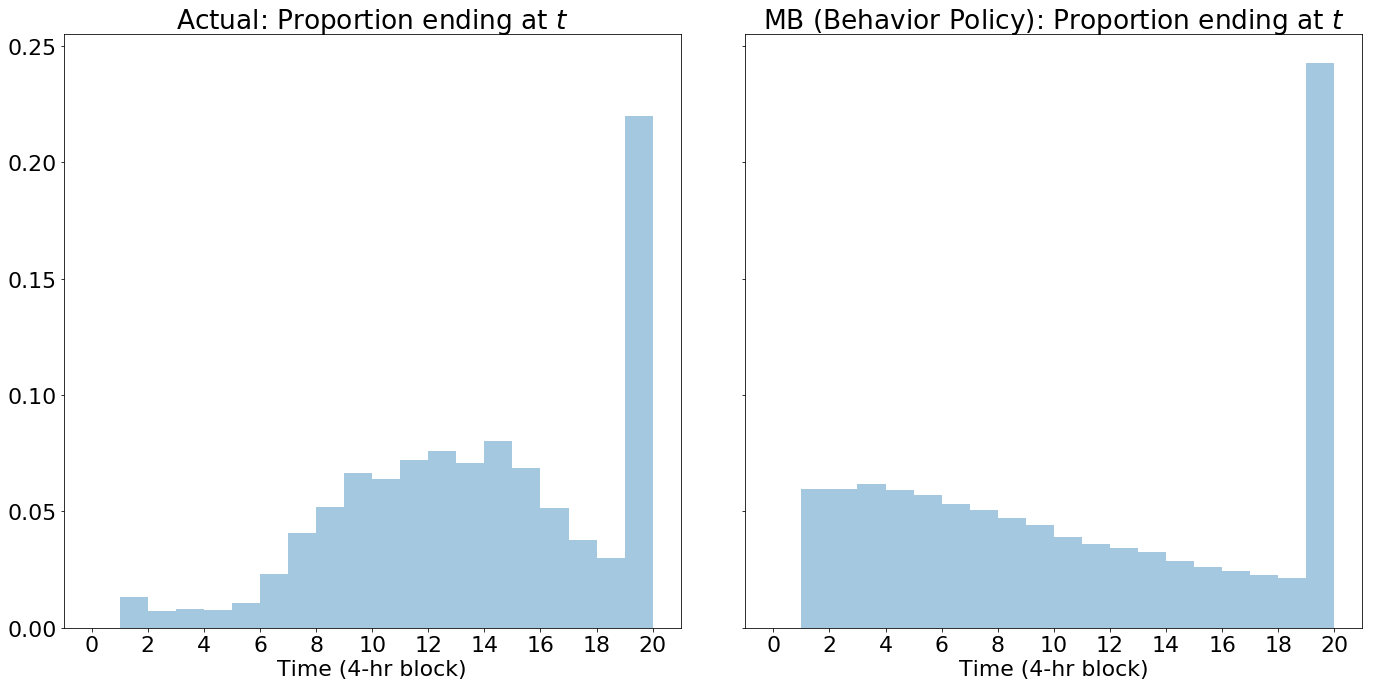

In [16]:
plt.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(1,2, sharex='col', sharey='row', figsize=(20,10))

sns.distplot(results_actual.loc[:, 'traj_len'], bins=range(21), kde=False, norm_hist=True, ax=axes[0])
sns.distplot(results_mb_b.loc[:, 'traj_len'], bins=range(21), kde=False, norm_hist=True, ax=axes[1])

for j in [0, 1]:#, 2]]:
    title = 'Actual: {}' if j == 0 else 'MB (Behavior Policy): {}' if j == 1 else 'MB (Target Policy): {}'
    axes[j].set_title(title.format('Proportion ending at $t$'))    
    axes[j].set_xlabel('Time (4-hr block)')
    axes[j].set_xticks(np.arange(21, step=2))

plt.tight_layout()
    
plt.show()

In [17]:
results_actual['death'] = results_actual['reward'] < 0
results_mb_b['death'] = results_mb_b['reward'] < 0

In [18]:
print((
    "\t & \t Average Reward & Pct. mortality & Trajectory length"
    "\n Train (Actual) &\t {:6.2f} & {:14.1%} & {:17.2f} "
    "\n Train (MB) &\t {:14.2f} & {:14.1%} & {:17.2f} "
    "\n Train (MB <20) & {:13.2f} & {:14.1%} & {:17.2f} ").format(
    results_actual['reward'].mean(),
    results_actual['death'].mean(),
    results_actual['traj_len'].mean(),
    results_mb_b['reward'].mean(),
    results_mb_b['death'].mean(),
    results_mb_b['traj_len'].mean(),
    results_mb_b[results_mb_b['traj_len'] != 20]['reward'].mean(),
    results_mb_b[results_mb_b['traj_len'] != 20]['death'].mean(),
    results_mb_b[results_mb_b['traj_len'] != 20]['traj_len'].mean()
))

	 & 	 Average Reward & Pct. mortality & Trajectory length
 Train (Actual) &	  59.25 &          20.4% &             13.37 
 Train (MB) &	          46.85 &          16.3% &             10.74 
 Train (MB <20) &         58.95 &          20.5% &              8.08 


## Miscalibration over Time 

In [24]:
p_initial_state = mdp_dict['train_raw']['mdp'].p_initial_state

est_tx_mat = mdp_dict['train_raw']['mdp'].tx_mat[0] # Cut off pesky component

In [25]:
# P(R | A, S), estimated from raw counts
prob_lives_a_s = est_tx_mat[:, :ncl, lives_state_idx]
prob_dies_a_s = est_tx_mat[:, :ncl, death_state_idx]
prob_noop_a_s = 1 - prob_lives_a_s - prob_dies_a_s
assert np.all(prob_noop_a_s >= 0)

In [26]:
# How to evaluate?  Most reasonable to compare on a state-for-state basis (i.e., predictions at actual states visited)
transitions = traj_train.copy().reset_index()#.query('bloc == @t')[['action_idx', 'from_state_idx', 'reward']]

# First let's get the relevant ground-truth labels and outcomes
transitions['lives'] = (transitions['reward'] == 100).astype(int)
transitions['dies'] = (transitions['reward'] == -100).astype(int)
transitions['noop'] = (transitions['reward'] == 0).astype(int)

transitions['prob_lives'] = prob_lives_a_s[transitions['action_idx'], transitions['from_state_idx']]
transitions['prob_dies'] = prob_dies_a_s[transitions['action_idx'], transitions['from_state_idx']]
transitions['prob_noop'] = prob_noop_a_s[transitions['action_idx'], transitions['from_state_idx']]

## Generating Figure 7a

In [28]:
import matplotlib.patches as patches

In [29]:
transitions['lives_or_dies'] = transitions[['lives','dies']].sum(axis=1)
transitions['prob_lives_or_dies'] = transitions[['prob_lives','prob_dies']].sum(axis=1)

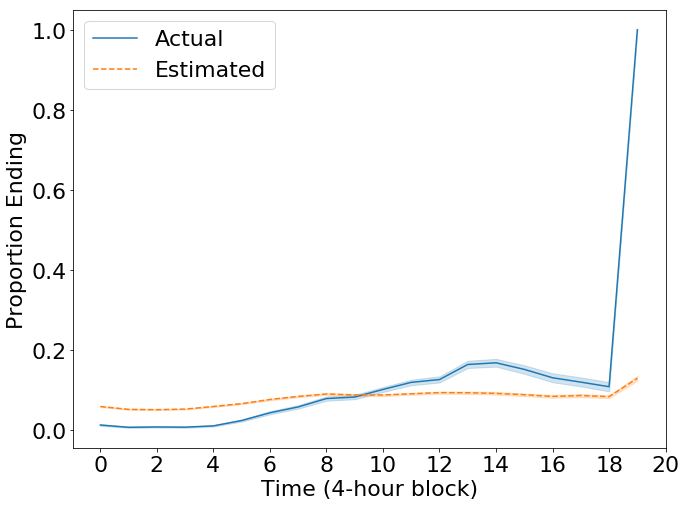

In [30]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(10,7.5))
sns.lineplot(x = 'bloc', y='lives_or_dies', data=transitions, label='Actual', ax=ax)#, seed=0)
sns.lineplot(x = 'bloc', y='prob_lives_or_dies', data=transitions, label='Estimated', ax=ax)#, seed=0)
ax.lines[0].set_linestyle('-')
ax.lines[1].set_linestyle('--')
#ax.lines[0].set_color('blue')
#ax.lines[1].set_color('orange')
ax.legend()
ax.set_ylabel('Proportion Ending')
ax.set_xlabel('Time (4-hour block)')
#ax.set_xlim([0,19])
#ax.set_ylim([0,0.2])
ax.set_xticks(np.arange(21, step=2))
plt.tight_layout()
plt.show()

In [31]:
# Overall, these are (naturally) perfectly calibrated!  Because this is the training set!
print("& Lives (Actual) & Lives (Est.) & Dies (Actual) & Dies (Est.)")
print("Overall: & {:.3f} & {:.3f} & {:.3f} & {:.3f}".format(
    *transitions.mean()[['lives', 'prob_lives', 'dies', 'prob_dies']].values.tolist()))
print("Before Cutoff: & {:.3f} & {:.3f} & {:.3f} & {:.3f}".format(
    *transitions.query('bloc < 19').mean()[['lives', 'prob_lives', 'dies', 'prob_dies']].values.tolist()))
print("At Cutoff: & {:.3f} & {:.3f} & {:.3f} & {:.3f}".format(
    *transitions.query('bloc == 19').mean()[['lives', 'prob_lives', 'dies', 'prob_dies']].values.tolist()))

& Lives (Actual) & Lives (Est.) & Dies (Actual) & Dies (Est.)
Overall: & 0.060 & 0.060 & 0.015 & 0.015
Before Cutoff: & 0.050 & 0.059 & 0.011 & 0.015
At Cutoff: & 0.697 & 0.089 & 0.303 & 0.041


## Generating Figure 7b

In [32]:
# Super hack to plot this data
plot_df_lives = transitions.query('bloc < 19')[['lives']].rename(columns={'lives': 'Probability'})
plot_df_lives['Lives/Dies'] = 'Lives'
plot_df_lives['Actual/Est'] = 'Actual'

plot_df_prob_lives = transitions.query('bloc < 19')[['prob_lives']].rename(columns={'prob_lives': 'Probability'})
plot_df_prob_lives['Lives/Dies'] = 'Lives'
plot_df_prob_lives['Actual/Est'] = 'Estimated'

plot_df_dies = transitions.query('bloc < 19')[['dies']].rename(columns={'dies': 'Probability'})
plot_df_dies['Lives/Dies'] = 'Dies'
plot_df_dies['Actual/Est'] = 'Actual'

plot_df_prob_dies = transitions.query('bloc < 19')[['prob_dies']].rename(columns={'prob_dies': 'Probability'})
plot_df_prob_dies['Lives/Dies'] = 'Dies'
plot_df_prob_dies['Actual/Est'] = 'Estimated'

plot_df = pd.concat([plot_df_lives, plot_df_prob_lives, plot_df_dies, plot_df_prob_dies])

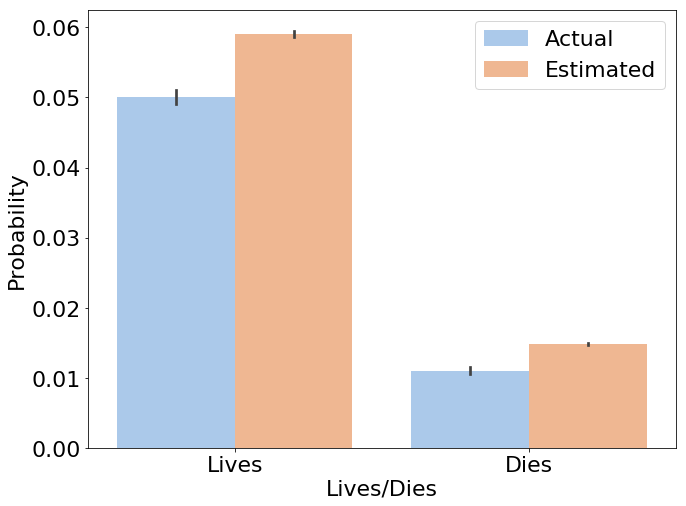

In [35]:
with sns.color_palette("pastel"):
    plt.rcParams.update({'font.size': 22})
    fig, ax = plt.subplots(figsize=(10,7.5))
    sns.barplot(x='Lives/Dies', y='Probability', hue='Actual/Est', data=plot_df, ci=95, n_boot=1000, ax=ax)#, seed=0)
    ax.legend()
    plt.tight_layout()
    plt.show()

## Computing other statistics in paper

Quote from paper: Of the 8271 training trajectories that end with discharge leading to survival, 4.9% end on non-zero vasopressor dosages, and 2.6% have large dosages

In [36]:
traj_train_reset_index = traj_train.reset_index()
traj_train_reset_index.sort_values(by=['icustayid','bloc'],inplace=True)
last_step_df = traj_train_reset_index.drop_duplicates(subset=['icustayid'],keep='last')
last_step_uncensored_survival_df \
    = last_step_df.loc[np.logical_and(last_step_df['bloc']<19, last_step_df['reward']==100)]
last_step_uncensored_survival_df['action_idx'].value_counts().sort_index()
# sum 1-4, 6-9, 11-14, 16-19, 21-24 for non-zero vasopressors
# sum 3-4, 8-9, 13-14, 18-19, 23-24 for large dosages

0     5201
1        8
2        5
3        8
4        3
5     1088
6       16
7       22
8       34
9        6
10     608
11      27
12      22
13      34
14      21
15     620
16      26
17      26
18      24
19      28
20     347
21       9
22      28
23      31
24      29
Name: action_idx, dtype: int64

Quote from paper: Of the model-based roll-outs (based on test trajectories) that end with discharge leading to survival, 52.8% end on non-zero vasopressor dosages, and 31.2% end with large dosages. This may be driven in part by censoring: Of the 1714 training trajectories that get censored but eventually lead to 90-day survival, 10.3% end on nonzero vasopressor dosages, and 5.6% are large dosages.

In [7]:
mb_dict = shelve.open("{}/mb_samples.db".format(datapath), flag='r')
test_samps_mb = mb_dict['test_samps_mb']
print('Total # test model-based roll-outs ending in discharge leading to survival: ' \
      + str(np.sum(np.where(np.logical_and(test_samps_mb[:,:,:,0]<19, test_samps_mb[:,:,:,3]==lives_state_idx),1,0))))
print('Total # test model-based roll-outs ending in discharge leading to survival and non-zero vasopressor dosages: ' \
      + str(np.sum(np.where(np.logical_and.reduce((test_samps_mb[:,:,:,0]<19, test_samps_mb[:,:,:,3]==lives_state_idx, \
                                                   test_samps_mb[:,:,:,1]%5>0)),1,0))))
print('Total # test model-based roll-outs ending in discharge leading to survival and large vasopressor dosages: ' \
      + str(np.sum(np.where(np.logical_and.reduce((test_samps_mb[:,:,:,0]<19, test_samps_mb[:,:,:,3]==lives_state_idx, \
                                                   test_samps_mb[:,:,:,1]%5>2)),1,0))))

Total # test model-based roll-outs ending in discharge leading to survival: 19538
Total # test model-based roll-outs ending in discharge leading to survival and non-zero vasopressor dosages: 10319
Total # test model-based roll-outs ending in discharge leading to survival and large vasopressor dosages: 6101


In [39]:
# Training trajectories
last_step_censored_survival_df \
    = last_step_df.loc[np.logical_and(last_step_df['bloc']==19, last_step_df['reward']==100)]
last_step_censored_survival_df['action_idx'].value_counts().sort_index()
# sum 1-4, 6-9, 11-14, 16-19, 21-24 for non-zero vasopressors
# sum 3-4, 8-9, 13-14, 18-19, 23-24 for large dosages

0     386
1       2
2       2
3       9
5     354
6       7
7       6
8       4
9       8
10    445
11     21
12      9
13     10
14      7
15    229
16      9
17     12
18      7
19     14
20    124
21      4
22      8
23     10
24     27
Name: action_idx, dtype: int64